# **Games with AVG starting player valuations**

In [172]:
import pandas as pd
valuations = pd.read_csv("player_valuations.csv")
valuations["date"] = pd.to_datetime(valuations.date)
valuations["season"] = valuations.apply(lambda x: x.date.year, axis=1)
valuations = valuations.groupby(["player_id", "season"]).max("market_value_in_eur").reset_index()
valuations = valuations[["player_id", "market_value_in_eur", "season"]]

games = pd.read_csv("games.csv")
games = games[[
    "game_id", "season", "home_club_id", "away_club_id",
    "home_club_goals", "away_club_goals", "home_club_position",
    "away_club_position"
]]

game_lineups = pd.read_csv("game_lineups.csv")
game_lineups = game_lineups[game_lineups["type"] == "starting_lineup"]
game_lineups = game_lineups[["game_id", "club_id", "player_id"]]

In [173]:
df = games.merge(game_lineups, on="game_id").merge(valuations, on=["player_id", "season"])
market_values = df.groupby(["game_id", "club_id"])[["market_value_in_eur"]].mean().reset_index()

In [174]:
df = games.merge(market_values, left_on=["game_id", "home_club_id"],
                 right_on=["game_id", "club_id"], suffixes=["", "_"])
df = df[[
    "game_id", "season", "home_club_id", "away_club_id", "home_club_position",
    "away_club_position", "home_club_goals",
    "away_club_goals", "market_value_in_eur"
]]

df.columns = [
    "game_id", "season", "home_club_id", "away_club_id", "home_club_position",
    "away_club_position", "home_club_goals",
    "away_club_goals", "home_avg_market_value"
]

df = df.merge(market_values, left_on=["game_id", "away_club_id"],
              right_on=["game_id", "club_id"], suffixes=["", "_"])
df = df[[
    "game_id", "season", "home_club_id", "away_club_id", "home_club_position",
    "away_club_position", "home_club_goals",
    "away_club_goals", "home_avg_market_value", "market_value_in_eur"
]]

df.columns = [
    "game_id", "season", "home_club_id", "away_club_id", "home_club_position",
    "away_club_position", "home_club_goals",
    "away_club_goals", "home_avg_market_value", "away_avg_market_value"
]

In [175]:
def result(data):
  home=data["home_club_goals"]
  away=data["away_club_goals"]
  if home > away:
    val = 1
  elif home == away:
    val = 0
  elif home < away:
    val = -1
  return val

df["result"] = df.apply(result, axis=1)
df["goal_dif"] = df["home_club_goals"] - df["away_club_goals"]

# **Baseline**

In [178]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [179]:
df = df.dropna()

In [180]:
X = df[["home_avg_market_value", "away_avg_market_value"]].to_numpy()
y = df["result"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [207]:
clf = make_pipeline(StandardScaler(), SVC(kernel="rbf"))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.48514851485148514


In [208]:
pd.DataFrame(y_pred).value_counts()

 1    131
-1     68
 0      3
dtype: int64

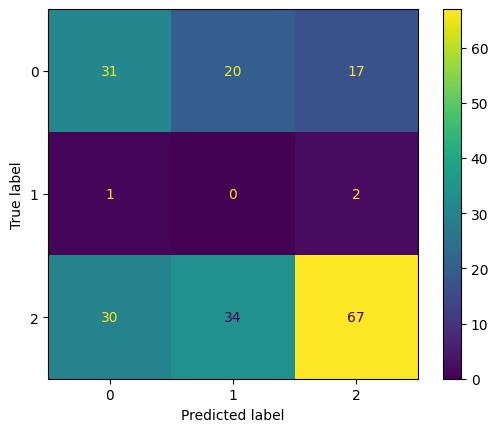

In [209]:
cm = metrics.confusion_matrix(y_pred, y_test)
cm_display = metrics.ConfusionMatrixDisplay(cm).plot()